# <span style="color:gray">Zestimate and Actual Sale Price Difference</span>

 ## <span style="color:black">1. Define</span>   
 Problem -  
 >Predict the log-error between their Zestimate and the actual sale price, given all the features of a home.  
 >  
             log-error=log(Zestimate)−log(SalePrice)  
 > 
 > Predict the logerror for the months in Fall 2017
 
 What we have - 
 >a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.  
 >The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.  
 >The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.  
 >4 Categorical/Qualitative - companyId, jobType, degree, major, industry  
 >2 Numeric/Quantitative - yearsExperience, milesFromMetropolis  
 
 Type of Algorithm -  
 >

 ## <span style="color:black">2. Discover</span> 

### <span style="color:black">2.1. Import Libraries</span> 

In [1]:
%%capture
! pip install seaborn
#import initial libraries
import pandas as pd
import numpy as np
from numpy import NaN
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 70)
#pd.set_option('display.width', 100)

In [2]:
import os
for dirname, _, filenames in os.walk('C:/Users/Manohar/Documents/DataScience/zillow/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
prop16 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/properties_2016.csv")
prop17 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/properties_2017.csv")
smplsub = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/sample_submission.csv")
train16 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/train_2016_v2.csv", parse_dates=["transactiondate"])
train17 = pd.read_csv("/Users/dad/Documents/GitHub/data/zillow/train_2017.csv", parse_dates=["transactiondate"])


/Users/dad/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/dad/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
prop16.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [5]:
def num_after_point(x):
    s = str(x)
    if not '.' in s:
        return 0
    return len(s) - s.index('.') - 1

In [6]:
def full_info(df):
    df_column=[]
    df_dtype=[]
    df_null=[]
    df_nullc=[]
    df_mean=[]
    df_median=[]
    df_std=[]
    df_min=[]
    df_max=[]
    df_uniq=[]
    for col in df.columns: 
        df_column.append( col)
        df_dtype.append( df[col].dtype)
        df_null.append( round(100 * df[col].isnull().sum(axis=0)/len(df[col]),2))
        df_nullc.append( df[col].isnull().sum(axis=0))
        df_uniq.append( df[col].nunique()) if df[col].dtype == 'object' else df_uniq.append( NaN)
        df_mean.append(  '{0:.2f}'.format(df[col].mean())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_mean.append( NaN)
        df_median.append( '{0:.2f}'.format(df[col].median())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_median.append( NaN)
        df_std.append( '{0:.2f}'.format(df[col].std())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_std.append( NaN)
        df_max.append( '{0:.2f}'.format(df[col].max())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_max.append( NaN)
        df_min.append( '{0:.2f}'.format(df[col].min())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_min.append( NaN)
    return pd.DataFrame(data = {'ColName': df_column, 'ColType': df_dtype, 'NullCnt': df_nullc, 'NullCntPrcntg': df_null,  'Min': df_min, 'Max': df_max, 'Mean': df_mean, 'Med': df_median, 'Std': df_std, 'UniqCnt': df_uniq})

In [7]:
prop16_Info = full_info(prop16)
prop16_Info.sort_values(by=['NullCnt'], ascending=False, inplace=True, ignore_index=True)
prop16_Info

,ColName,ColType,NullCnt,NullCntPrcntg,Min,Max,Mean,Med,Std,UniqCnt
0,storytypeid,float64,2983593,99.95,7.00,7.00,7.00,7.00,0.00,NaN
1,basementsqft,float64,2983589,99.95,20.00,8516.00,646.88,534.00,538.79,NaN
2,yardbuildingsqft26,float64,2982570,99.91,10.00,6141.00,278.30,168.00,369.73,NaN
3,fireplaceflag,object,2980054,99.83,NaN,NaN,NaN,NaN,NaN,1.0
4,architecturalstyletypeid,float64,2979156,99.80,2.00,27.00,7.20,7.00,2.44,NaN
5,typeconstructiontypeid,float64,2978470,99.77,4.00,13.00,6.00,6.00,0.38,NaN
6,finishedsquarefeet13,float64,2977545,99.74,120.00,2688.00,1178.90,1296.00,357.07,NaN
7,buildingclasstypeid,float64,2972588,99.58,1.00,5.00,3.73,4.00,0.50,NaN
8,decktypeid,float64,2968121,99.43,66.00,66.00,66.00,66.00,0.00,NaN
9,finishedsquarefeet6,float64,2963216,99.26,117.00,952576.00,2414.34,1992.00,7695.30,NaN


In [8]:
prop16[['taxvaluedollarcnt', 'taxamount']]

,taxvaluedollarcnt,taxamount
0,9.0,NaN
1,27516.0,NaN
2,1413387.0,20800.37
3,1156834.0,14557.57
4,433491.0,5725.17
...,...,...
2985212,NaN,NaN
2985213,NaN,NaN
2985214,NaN,NaN
2985215,NaN,NaN


In [9]:
train16.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [10]:
full_info(train16)

,ColName,ColType,NullCnt,NullCntPrcntg,Min,Max,Mean,Med,Std,UniqCnt
0,parcelid,int64,0,0.0,10711738.00,162960842.00,12984656.11,12547337.00,2504510.49,NaN
1,logerror,float64,0,0.0,-4.61,4.74,0.01,0.01,0.16,NaN
2,transactiondate,datetime64[ns],0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print('size of properties_2016.csv: ', prop16.shape)
print('size of train_2016_v2.csv: ', train16.shape)
#print('size of properties_2017.csv: ', prop17.shape)
#print('size of train_2017.csv: ', train17.shape)

size of properties_2016.csv:  (2985217, 58)
size of train_2016_v2.csv:  (90275, 3)


In [12]:
unique_props = len(train16['parcelid'].unique())
multiple_sales = len(train16) - unique_props
print('number of unique sales: ', unique_props)
print('Number of duplicate: ', multiple_sales)

number of unique sales:  90150
Number of duplicate:  125


In [13]:
smplsub.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


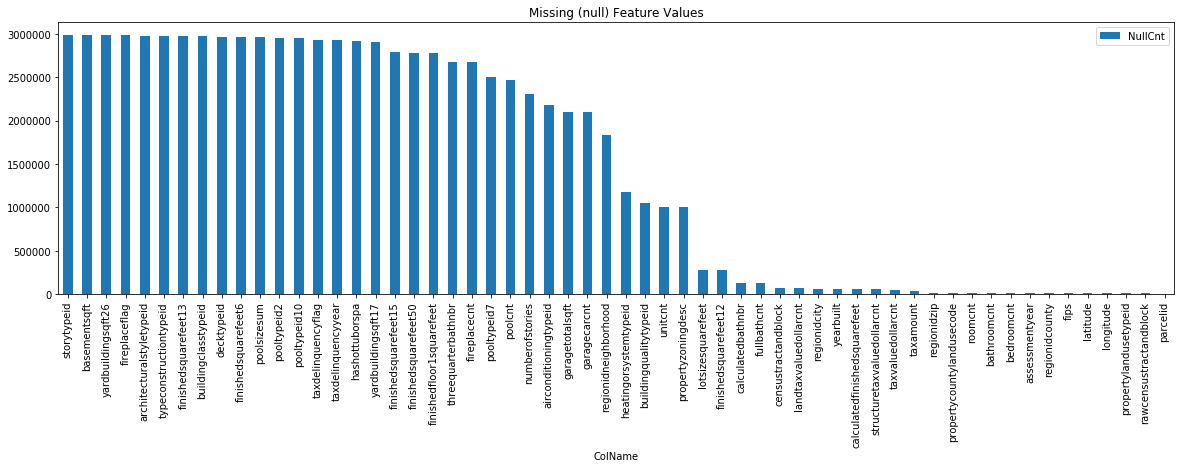

In [14]:
prop16_Info.plot.bar(x = 'ColName', y = 'NullCnt', figsize=(20, 5),rot=90, title='Missing (null) Feature Values')

In [15]:
prop16_trim = prop16.drop(prop16_Info[(prop16_Info.NullCntPrcntg>=90)].ColName.values.tolist(),
                    axis=1)

In [16]:
prop16_trim

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,10754147,NaN,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN
1,10759547,NaN,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN
2,10843547,NaN,0.0,0.0,NaN,NaN,73026.0,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,2.0,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN
3,10859147,NaN,0.0,0.0,7.0,NaN,5068.0,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN
4,10879947,NaN,0.0,0.0,NaN,NaN,1776.0,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,1.0,1947.0,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
prop16_trim.select_dtypes(include=['object']).columns

Index(['propertycountylandusecode', 'propertyzoningdesc'], dtype='object')

In [18]:
prop16_trim[['propertycountylandusecode', 'propertyzoningdesc']]

,propertycountylandusecode,propertyzoningdesc
0,010D,NaN
1,0109,LCA11*
2,1200,LAC2
3,1200,LAC2
4,1210,LAM1
...,...,...
2985212,NaN,NaN
2985213,NaN,NaN
2985214,NaN,NaN
2985215,NaN,NaN


In [19]:
 prop16_trim=prop16_trim.drop(['propertycountylandusecode', 'propertyzoningdesc'],axis=1)

In [20]:
prop16_mean_imputed = prop16_trim.fillna(prop16_trim.mean())
prop16_mean_imputed

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,10754147,1.931166,0.000000,0.000000,5.784787,2.299263,1827.162124,1760.000608,6037.0000,1.16871,2.244165,1.823517,383.769357,4.012053,3.414444e+07,-1.186541e+08,85768.000000,1.0,1.0,269.000000,6.037800e+07,37688.000000,3101.000000,193476.407415,96337.0000,0.000000,1.010009,1.181171,1964.261641,1.401464,170883.577166,9.000000e+00,2015.000000,9.000000,5377.607139,6.048431e+13
1,10759547,1.931166,0.000000,0.000000,5.784787,2.299263,1827.162124,1760.000608,6037.0000,1.16871,2.244165,1.823517,383.769357,4.012053,3.414043e+07,-1.186254e+08,4083.000000,1.0,1.0,261.000000,6.037800e+07,37688.000000,3101.000000,193476.407415,96337.0000,0.000000,1.010009,1.181171,1964.261641,1.401464,170883.577166,2.751600e+04,2015.000000,27516.000000,5377.607139,6.048431e+13
2,10843547,1.931166,0.000000,0.000000,5.784787,2.299263,73026.000000,1760.000608,6037.0000,1.16871,2.244165,1.823517,383.769357,4.012053,3.398936e+07,-1.183946e+08,63085.000000,1.0,1.0,47.000000,6.037703e+07,51617.000000,3101.000000,193476.407415,96095.0000,0.000000,1.010009,2.000000,1964.261641,1.401464,650756.000000,1.413387e+06,2015.000000,762631.000000,20800.370000,6.048431e+13
3,10859147,1.931166,0.000000,0.000000,7.000000,2.299263,5068.000000,1760.000608,6037.0000,1.16871,2.244165,1.823517,383.769357,4.012053,3.414886e+07,-1.184372e+08,7521.000000,1.0,1.0,47.000000,6.037141e+07,12447.000000,3101.000000,27080.000000,96424.0000,0.000000,1.010009,1.181171,1948.000000,1.000000,571346.000000,1.156834e+06,2015.000000,585488.000000,14557.570000,6.048431e+13
4,10879947,1.931166,0.000000,0.000000,5.784787,2.299263,1776.000000,1760.000608,6037.0000,1.16871,2.244165,1.823517,383.769357,4.012053,3.419417e+07,-1.183858e+08,8512.000000,1.0,1.0,31.000000,6.037123e+07,12447.000000,3101.000000,46795.000000,96450.0000,0.000000,1.010009,1.000000,1947.000000,1.401464,193796.000000,4.334910e+05,2015.000000,239695.000000,5725.170000,6.048431e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,1.931166,2.209143,3.088949,5.784787,2.299263,1827.162124,1760.000608,6048.0316,1.16871,2.244165,1.823517,383.769357,4.012053,3.400147e+07,-1.182019e+08,22822.805528,1.0,1.0,260.048429,6.048345e+07,34993.350224,2570.460554,193476.407415,96552.6728,1.475018,1.010009,1.181171,1964.261641,1.401464,170883.577166,4.204790e+05,2014.999459,252478.029469,5377.607139,6.048431e+13
2985213,14273630,1.931166,2.209143,3.088949,5.784787,2.299263,1827.162124,1760.000608,6048.0316,1.16871,2.244165,1.823517,383.769357,4.012053,3.400147e+07,-1.182019e+08,22822.805528,1.0,1.0,260.048429,6.048345e+07,34993.350224,2570.460554,193476.407415,96552.6728,1.475018,1.010009,1.181171,1964.261641,1.401464,170883.577166,4.204790e+05,2014.999459,252478.029469,5377.607139,6.048431e+13
2985214,168040630,1.931166,2.209143,3.088949,5.784787,2.299263,1827.162124,1760.000608,6048.0316,1.16871,2.244165,1.823517,383.769357,4.012053,3.400147e+07,-1.182019e+08,22822.805528,1.0,1.0,260.048429,6.048345e+07,34993.350224,2570.460554,193476.407415,96552.6728,1.475018,1.010009,1.181171,1964.261641,1.401464,170883.577166,4.204790e+05,2014.999459,252478.029469,5377.607139,6.048431e+13
2985215,168040830,1.931166,2.209143,3.088949,5.784787,2.299263,1827.162124,1760.000608,6048.0316,1.16871,2.244165,1.823517,383.769357,4.012053,3.400147e+07,-1.182019e+08,22822.805528,1.0,1.0,260.048429,6.0483

In [21]:
prop16_median_imputed = prop16_trim.fillna(prop16_trim.median())
prop16_median_imputed

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,10754147,1.0,0.0,0.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34144442.0,-118654084.0,85768.0,1.0,1.0,269.0,6.037800e+07,37688.0,3101.0,118920.0,96337.0,0.0,1.0,1.0,1963.0,1.0,122590.0,9.0,2015.0,9.0,3991.78,6.037572e+13
1,10759547,1.0,0.0,0.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34140430.0,-118625364.0,4083.0,1.0,1.0,261.0,6.037800e+07,37688.0,3101.0,118920.0,96337.0,0.0,1.0,1.0,1963.0,1.0,122590.0,27516.0,2015.0,27516.0,3991.78,6.037572e+13
2,10843547,1.0,0.0,0.0,7.0,2.0,73026.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,33989359.0,-118394633.0,63085.0,1.0,1.0,47.0,6.037703e+07,51617.0,3101.0,118920.0,96095.0,0.0,1.0,2.0,1963.0,1.0,650756.0,1413387.0,2015.0,762631.0,20800.37,6.037572e+13
3,10859147,1.0,0.0,0.0,7.0,2.0,5068.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34148863.0,-118437206.0,7521.0,1.0,1.0,47.0,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,1.0,1.0,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57,6.037572e+13
4,10879947,1.0,0.0,0.0,7.0,2.0,1776.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34194168.0,-118385816.0,8512.0,1.0,1.0,31.0,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,1.0,1.0,1947.0,1.0,193796.0,433491.0,2015.0,239695.0,5725.17,6.037572e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13
2985213,14273630,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13
2985214,168040630,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13
2985215,168040830,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13


In [22]:
train16_merge = pd.merge(prop16_median_imputed, train16, on='parcelid', how='left')
train16_merge

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate
0,10754147,1.0,0.0,0.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34144442.0,-118654084.0,85768.0,1.0,1.0,269.0,6.037800e+07,37688.0,3101.0,118920.0,96337.0,0.0,1.0,1.0,1963.0,1.0,122590.0,9.0,2015.0,9.0,3991.78,6.037572e+13,NaN,NaT
1,10759547,1.0,0.0,0.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34140430.0,-118625364.0,4083.0,1.0,1.0,261.0,6.037800e+07,37688.0,3101.0,118920.0,96337.0,0.0,1.0,1.0,1963.0,1.0,122590.0,27516.0,2015.0,27516.0,3991.78,6.037572e+13,NaN,NaT
2,10843547,1.0,0.0,0.0,7.0,2.0,73026.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,33989359.0,-118394633.0,63085.0,1.0,1.0,47.0,6.037703e+07,51617.0,3101.0,118920.0,96095.0,0.0,1.0,2.0,1963.0,1.0,650756.0,1413387.0,2015.0,762631.0,20800.37,6.037572e+13,NaN,NaT
3,10859147,1.0,0.0,0.0,7.0,2.0,5068.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34148863.0,-118437206.0,7521.0,1.0,1.0,47.0,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,1.0,1.0,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57,6.037572e+13,NaN,NaT
4,10879947,1.0,0.0,0.0,7.0,2.0,1776.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34194168.0,-118385816.0,8512.0,1.0,1.0,31.0,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,1.0,1.0,1947.0,1.0,193796.0,433491.0,2015.0,239695.0,5725.17,6.037572e+13,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985337,168176230,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,NaN,NaT
2985338,14273630,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,NaN,NaT
2985339,168040630,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,NaN,NaT
2985340,168040830,1.0,2.0,3.0,7.0,2.0,1572.0,1539.0,6037.0,1.0,2.0,2.0,441.0,2.0,34008249.0,-118172540.5,7000.0,1.0,1.0,261.0,6.037571e+07,25218.0,3101.0,118920.0,96377.0,0.0,1.0,1.0,1963.0,1.0,122590.0,306086.0,2015.0,167042.0,3991.78,6.037572e+13,NaN,NaT


In [23]:
 train16_merge=train16_merge.drop(['parcelid'],axis=1)

In [24]:
train16_merge['propage'] = 2018 - train16_merge['yearbuilt']  # property age
train16_merge['propage']

0          55.0
1          55.0
2          55.0
3          70.0
4          71.0
           ... 
2985337    55.0
2985338    55.0
2985339    55.0
2985340    55.0
2985341    55.0
Name: propage, Length: 2985342, dtype: float64

In [25]:
import lightgbm as lgb
import random

In [26]:
#x_train = x_train.values.astype(np.float32, copy=False) 

In [28]:
x_train = train16_merge.drop(columns =[ 'logerror', 'transactiondate', 'fireplacecnt']).values # np array
y_train = train16_merge['logerror'].values  # np array
x_test = train16_merge.drop([ 'logerror', 'transactiondate', 'fireplacecnt'], axis=1).values  # np array
train_columns = train16_merge.drop(columns = [ 'logerror', 'transactiondate', 'fireplacecnt']).columns 


In [29]:
d_train = lgb.Dataset(x_train, y_train, feature_name=['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet', 'fips',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'pooltypeid', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'propage'])  # lightgbm data model

In [30]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.01  # shrinkage_rate 0.0021 grid search = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'  # l1
params['sub_feature'] = 0.5  # feature_fraction
params['bagging_fraction'] = 0.85  # sub_row
params['num_leaves'] = 512  # num_leaf
params['min_data'] = 500  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3
#params['n_estimators'] = 10  # grid search
params['colsample_bytree'] = 0.85
params['num_leaves'] = 22
params['subsample'] = 0.7

np.random.seed(0)
random.seed(0)

clf = lgb.train(params, d_train, 430)

In [31]:
#x_test = x_test.values.astype(np.float32, copy=False)

p_test = clf.predict(x_test)

In [32]:
pd.DataFrame(p_test).head()

,0
0,-0.000213
1,-0.000235
2,0.000263
3,-0.000371
4,-0.000226


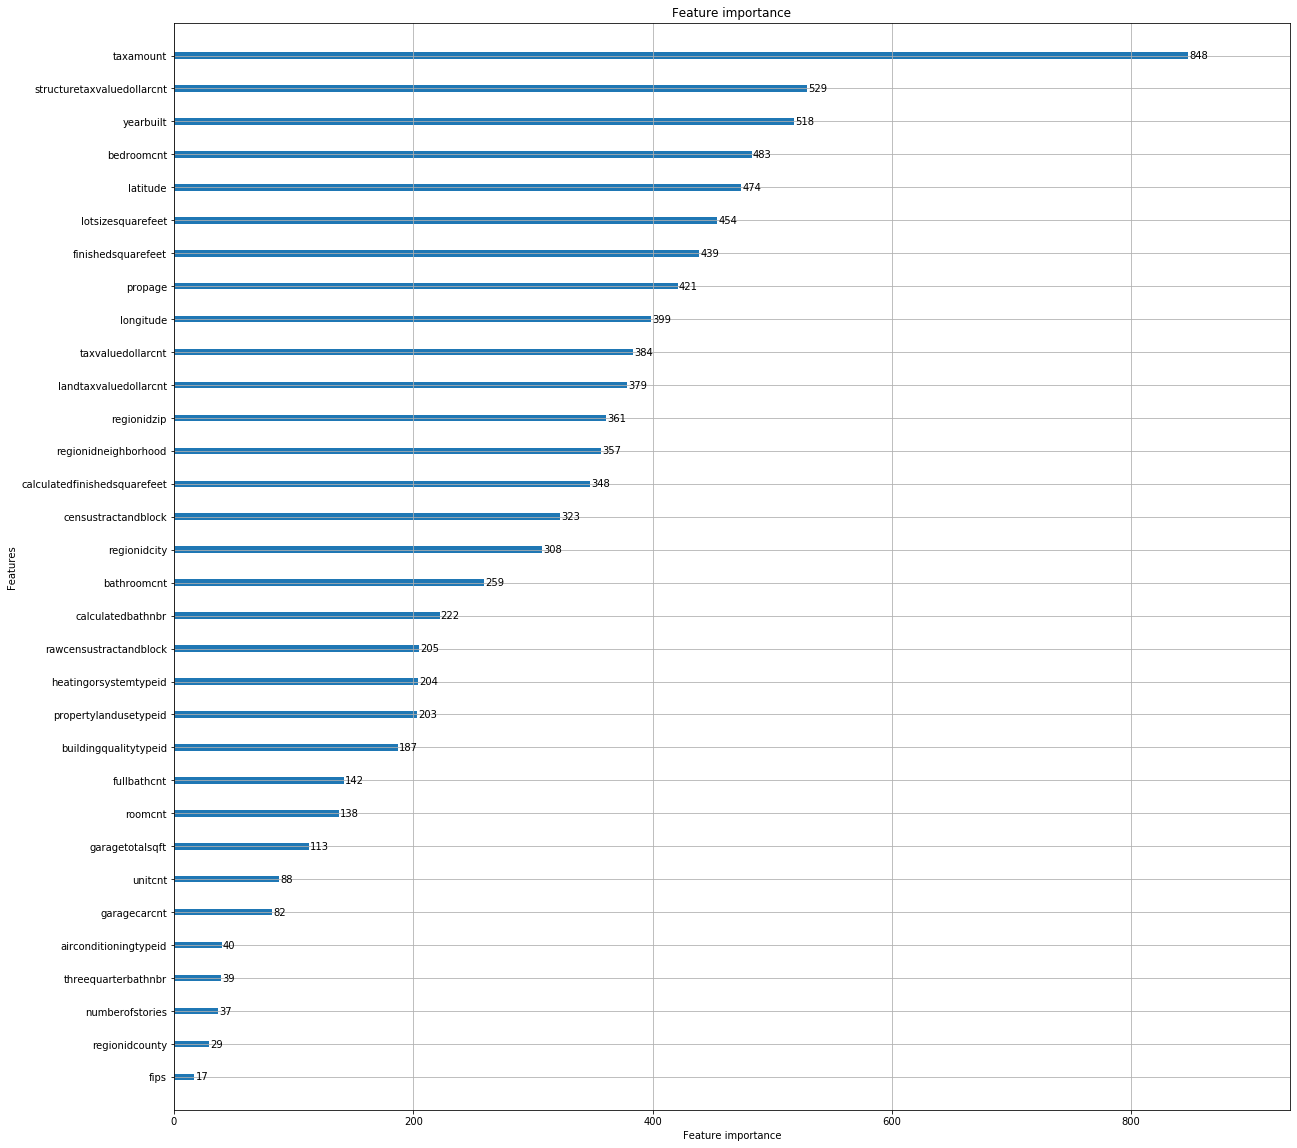

In [33]:
lgb.plot_importance(clf, figsize=(20,20))

In [ ]:
#import os
#os.environ["PATH"] += os.pathsep + '/usr/bin'
#ax = lgb.plot_tree(clf)
#plt.show()
#lgb.plot_tree(clf, figsize=(20,20))

In [ ]:
#from dtreeplt import dtreeplt
#dtree = dtreeplt(model = clf, feature_names=train_columns,  target_names=['logerror'], filled=True)
#dtree.view()


In [38]:
import xgboost as xgb
y_mean = np.mean(y_train)
xgb_params = {
    'eta' : 0.04,  # 0.037 grid search = .04
    'max_depth' : 6,  #5
    'subsample' : 0.80,
    'objective' : 'reg:linear',
    'eval_metric' : 'mae',
    'lambda' : 0.8,
    'alpha' : 0.4,
    'base_score' : y_mean,
    'silent' : 1,
    'min_child_weight': 5  # grid search
}

In [39]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [41]:
num_boost_rounds = 250 

# training
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

# predict
xgb_pred1 = model.predict(dtest)
xgb_pred1

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [44]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(20, 20)

ValueError: Booster.get_score() results in empty